In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm import tqdm
import sys
import matplotlib as mpl

sys.modules.pop('generate_syn_data', None)
from generate_syn_data import *

In [ ]:
#TODO: also save the general sample size version

#TODO: single sided quantile estimation
#TODO: mean estimation using fixed window, and make prediction set
#TODO: linear regression

In [12]:
#ARW functions
import numpy as np

#compute cdfhat(q)

def expand_U_tk(U):
    U_all = np.full((len(U), len(U)), np.nan)
    for i in range(len(U)):
        end_index = len(U) - i  
        U_all[i, :end_index] = U[i:]
        
    return U_all

def cdfhat(q, arr):
    count_leq = np.count_nonzero(arr <= q) 
    quantile = count_leq / len(arr)  
    return quantile

def cdfhat_arr(q, arr):
    q = q[:, np.newaxis]  # Convert q to column vector for broadcasting
    cdf_values = np.mean(arr <= q, axis=1)  # Broadcast comparison over arr and calculate mean
    return cdf_values

#compute psi_tk for all k
def compute_psi(Btk_all, alpha, delta):
    sigma_bin = alpha *(1-alpha) 

    #NOTE: this part can be changed
    psi_all = np.sqrt(2 * sigma_bin * np.log(1/delta) / Btk_all)
    #psi_1_all = 1.5 * np.sqrt(2 * sigma_bin * np.log(4/delta) / Btk_all) + (19/4) * np.log(4/delta) / Btk_all
    #psi_2_all = np.sqrt(2 * sigma_bin * np.log(4/delta) / Btk_all) + (19/6) * np.log(4/delta) / Btk_all

    return psi_all

# Compute summary statistics

def prepare(U, B_arr, alpha):
    """Compute B_tk, mu_hat_tk and v_hat_tk for all k
    Args:
        U (np.array): 1D array of length B_1 + ... + B_t
        B_arr: (np.array) stores the sample size for each period
        alpha: quantile level
        delta: exceptional probability
    Returns:
        Btk_all, qtk_all, Fti_qtk_all
    """
    t = len(B_arr)
    B_arr = np.ones(t)
    period_starts = np.arange(t)
   
    """ U_expand = expand_U_tk(U)
    qtk_all = np.nanquantile(U_expand, 1-alpha, axis=0)[::-1]
    """
    #TODO: time this
    qtk_all = np.array( [np.quantile( U[period_starts[i]:], 1-alpha, method='inverted_cdf') for i in range(t)] )[::-1]

    Fti_qtk_all = np.zeros((t,t))

    #TODO: time this; only do k>i part for qtk_all
    for i in range(t):
        Fti_qtk_all[i,i:] = cdfhat_arr(qtk_all[i:], U[period_starts[t-i-1]:])
   
    return qtk_all, Fti_qtk_all

# Goldenshluger-Lepski procedure

def ARWQE(U, B_arr, psi_all, qtk_all, Fti_qtk_all, alpha, gamma=1):

    """ Adaptive Rolling Window Mean Estimation(ARWME): selecting the best window size
    Args:
        U (np.array): 1D array of length B_1 + ... + B_t
        B_arr: (np.array) stores the sample size for each period
        alpha: quantile level
        delta: exceptional probability

    Returns:
        k_hat +1 (int): best window size
        qtk_all[k_hat] (float): best quantile estimate
    """

    t = len(B_arr)
    

    # Compute phi_hat_k for all k
    t_arr = np.arange(1, t+1)
    t_starts = np.cumsum(t_arr) - t_arr
    t_ends = np.cumsum(t_arr)

    phi_hat_all = np.empty(t)
    for k in range(t):
        tmp = np.array([ np.abs(Fti_qtk_all[i, t_starts[k]: t_ends[k]]
                    - (1-alpha)) - (psi_all[k] - psi_all[i])*gamma for i in range(k + 1) ])
        tmp[tmp < 0] = 0
        phi_hat_all[k] = np.max(tmp)

    # Choose k_hat
    k_hat = np.argmin(phi_hat_all + psi_all)
    return k_hat+1, qtk_all[t-1, k_hat]

In [3]:
def prepare_qtk_all(U, B_arr, alpha):
    n = len(B_arr)
    period_ends = np.cumsum(B_arr)
    period_starts = period_ends - B_arr

    qtk_all = np.zeros((n,n))

    for t in range(n):
        qtk_all[t, :t+1] = np.array( [np.quantile( \
            U[period_starts[i]:period_ends[t]], \
                1-alpha, method='inverted_cdf') for i in range(t+1)] )[::-1]

    return qtk_all

In [4]:
def subarr_sums(array):
    n = len(array)
    
    # Reverse the array for backward processing
    reversed_array = array[::-1]
    
    # Compute prefix sums for the reversed array
    prefix_sums = np.zeros(n + 1, dtype=int)
    prefix_sums[1:] = np.cumsum(reversed_array)
    
    # List to hold all subarray averages
    all_sums = []
    
    for start in range(n):
        
        # Sums from 'start' to all 'end' indices greater than 'start'
        sub_sums = prefix_sums[start + 1:] - prefix_sums[start]
        
        all_sums.extend(sub_sums)

    return all_sums
#given q, compute the number of elements in an array smaller than or equal to q
U = np.random.normal(0, 1, 10)
qtk = np.array([0.5, 0.2, 0.8])
leq = np.greater_equal.outer(U, qtk)
print(leq.shape)

(10, 3)


In [5]:
def cdfhat_forall_subarr_2d(array, B_arr):
    n, m = array.shape  

    # Prepare Btk_all from B_arr for subarray sums
    Btk_all = np.array(subarr_sums(B_arr))
    Btk_all_end = np.cumsum(np.arange(n, 0, -1))
    Btk_all_start = Btk_all_end - np.arange(n, 0, -1)

    # Compute prefix sums for the reversed array along each column
    reversed_array = array[::-1, :]
    prefix_sums = np.zeros((n + 1, m), dtype=int)
    prefix_sums[1:, :] = np.cumsum(reversed_array, axis=0)

    # Prepare an array to hold all subarray averages for each column
    all_averages = np.empty((Btk_all_end[-1], m), dtype=object)  # Use object type to hold variable-length arrays

    # Vectorized computation for each start index across all columns
    for start in range(n):
        # Get Btk
        lengths = Btk_all[Btk_all_start[start]:Btk_all_end[start]]

        # Sums from 'start' to all 'end' indices greater than 'start'
        sub_sums = prefix_sums[start + 1:, :] - prefix_sums[start, np.newaxis, :]

        # Calculate averages by dividing sums by their respective lengths, broadcasting lengths appropriately
        sub_averages = np.divide(sub_sums, lengths[:, np.newaxis])
        #print('sub_averages:\n', sub_averages)

        all_averages[Btk_all_start[start]: Btk_all_end[start], :] = sub_averages

    return all_averages

# Example usage
array = np.array([
    [1, 2],
    [0, 1],
    [1, 0],
])

B_arr = np.array([1, 2, 3])  # 1D array used across all columns
n = len(B_arr)

Btk_all = np.array(subarr_sums(B_arr))
Btk_all_end = np.cumsum(np.arange(n, 0, -1))
Btk_all_start = Btk_all_end - np.arange(n, 0, -1)

averages = cdfhat_forall_subarr_2d(array, B_arr)
print(averages)
for t in range(n):
    print('t =', t) 
    print(averages[Btk_all_start[n-t-1]:Btk_all_end[n-t-1]])

[[0.3333333333333333 0.0]
 [0.2 0.2]
 [0.3333333333333333 0.5]
 [0.0 0.5]
 [0.3333333333333333 1.0]
 [1.0 2.0]]
t = 0
[[1.0 2.0]]
t = 1
[[0.0 0.5]
 [0.3333333333333333 1.0]]
t = 2
[[0.3333333333333333 0.0]
 [0.2 0.2]
 [0.3333333333333333 0.5]]


In [21]:
trials_per_var = 1
num_periods = 100
alpha = 0.1; delta = 0.1; gamma=1

fixed_windows = [1, 4, 16, 64, 256, 1024]

#stationary case
true_means = 10 * np.ones(num_periods)

#NOTE: uncomment to change cases

#non-stationary case
#true_means = 5 * generate_true_means(num_periods-1, 3)
#true_means = 2 * np.sin(np.linspace(0, 5*np.pi, num_periods)) + 5

#plt.plot(true_means)
#plt.show()

B_arr = np.random.randint(low=1, high=2, size=num_periods)
B_arr_starts = np.cumsum(B_arr) - B_arr
B_arr_ends = np.cumsum(B_arr) - 1

Btk_all = np.array(subarr_sums(B_arr))
Btk_all_end = np.cumsum(np.arange(num_periods, 0, -1))
Btk_all_start = Btk_all_end - np.arange(num_periods, 0, -1)

Btk_all = np.arange(1, num_periods+1)
psi_all = compute_psi(Btk_all, alpha, delta)

#seeds for the trials
#variances = [0.01, 0.1, 1]
variances = [1]
seeds = np.arange(len(variances) * trials_per_var)

#initialize dictionary for storing the results
CDF_dict = {}
CDF_dict['ARW'] = {}
for k in fixed_windows:
    CDF_dict[f'Val_{k}'] = {}
    for variance in variances:
        CDF_dict[f'Val_{k}'][variance] = {}
        CDF_dict['ARW'][variance] = {}
        for trial in range(trials_per_var):
            CDF_dict[f'Val_{k}'][variance][trial] = []
            CDF_dict['ARW'][variance][trial] = []


for (trial, seed) in tqdm(enumerate(seeds)):

    np.random.seed(seed)
    variance = variances[trial // trials_per_var]

    U = generate_gaussian_sequence(B_arr = B_arr, true_means = true_means, variance=variance)

    qtk_all = prepare_qtk_all(U, B_arr, alpha)
    #take lower triangular indices
    tril_idx = np.tril_indices(num_periods)
    qtk_tril = qtk_all[tril_idx]

    qtk_leq = np.greater_equal.outer(U, qtk_tril)
    Fti_qtk_all = cdfhat_forall_subarr_2d(qtk_leq, B_arr)
    print(Fti_qtk_all.shape)
    #k_hat_all = []
    
    for t in range(num_periods):
            
        mu_t = true_means[t]

        U_t = U[:B_arr_ends[t]+1]
        B_arr_t = B_arr[:t+1]

        F_start = Btk_all_start[num_periods- t-1]
        F_end = Btk_all_end[num_periods - t-1]

        khat, qt_khat = ARWQE(U_t, B_arr_t, psi_all[:t+1], qtk_all, Fti_qtk_all[F_start:F_end], alpha, gamma)
        #print(Fti_qtk_all[F_start:F_end].shape)
        #k_hat_all.append(khat)
        coverage = norm.cdf(qt_khat, mu_t, np.sqrt(variance))
        CDF_dict['ARW'][variance][trial % trials_per_var].append( np.abs( coverage - (1-alpha) ))

        #baseline: take quantile of fixed k 
        for ik, k in enumerate(fixed_windows):
            coverage = norm.cdf(qtk_all[t, min(k,t)], mu_t, np.sqrt(variance))
            CDF_dict[f'Val_{k}'][variance][trial % trials_per_var].append(np.abs(coverage - (1-alpha)))
            
    #k_hat_all = np.array(k_hat_all)
    #print(k_hat_all)
    #plt.plot(k_hat_all)
    #plt.show()

0it [00:00, ?it/s]

(5050, 5050)


1it [00:02,  2.25s/it]


[[0.12356475]
 [0.12540429]
 [0.07609546]
 [0.07774044]
 [0.07774044]
 [0.07774044]
 [0.07774044]]
Variance: 1


ValueError: The number of FixedLocator locations (7), usually from a call to set_ticks, does not match the number of labels (3).

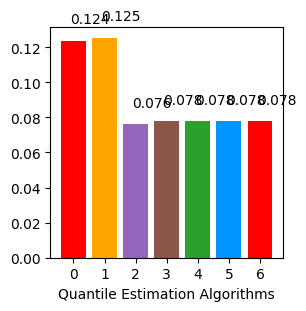

In [19]:
#process results
methods = ['ARW'] + [f'Val_{k}' for k in fixed_windows]
num_methods = len(methods)

#save result dictionary to numpy array
CDF_array = np.zeros((len(methods), len(variances), trials_per_var, num_periods))
rel_error = np.zeros((len(methods), len(variances), trials_per_var, num_periods))
for (i, key) in enumerate(CDF_dict.keys()):
    for (j, variance) in enumerate(CDF_dict[key].keys()):
        for (trial, trial_CDF) in CDF_dict[key][variance].items():
            #record square errors 
            CDF_array[i, j, trial, :] = trial_CDF

#take average of cdf over time and trials for each variance (n_model * n_variance)
cdf_mean_over_variances = np.mean(np.mean(CDF_array[:, :, :, :], axis=3), axis=2)
print(cdf_mean_over_variances)
#take average of cdf over for each trial (n_model * n_variance * n_periods)
cdf_mean_over_trials = np.mean(CDF_array, axis=2)

#plot results
colors = ['r', '#FFA500', 'tab:purple', 'tab:brown', 'tab:green', '#0096FF']

for (idx, variance) in enumerate(variances):
    print(f'Variance: {variance}')
    #for each variance, barplot mean MSE of each method
    fig, ax = plt.subplots(1, 1, figsize = (3, 3))    
    ax.bar(range(num_methods), cdf_mean_over_variances[:, idx], color=colors, \
           width = 0.8)
    #show number on yaxis
    for i, v in enumerate(cdf_mean_over_variances[:, idx]):
        ax.text(i - 0.1, v + 0.01, f'{v:.3f}', color='black')
    ax.set_xlabel('Quantile Estimation Algorithms')
    ax.set_xticks(range(num_methods))
    ax.set_xticklabels(['ARW', 'V1','Vfull'])
    ax.set_ylabel(r'Mean $|F_t(\widehat{q}_{t,\hat{k}}) - (1-\alpha)|$')
    mpl.rcParams.update({'font.size': 10})
    plt.tight_layout()
    plt.show()
    
    #uncomment to save the figure
    #plt.savefig(f'{DATAPATH}/{figname}_var{variance}.png', dpi=300, bbox_inches='tight')

#TODO: discard the first ~100 periods